
*Note:* You can run this from your computer (Jupyter or terminal), or using Binder (does not require any installation, takes a few minutes to be ready)

[![binder-logo](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/ploomber/binder-env/main?urlpath=git-pull%3Frepo%3Dhttps%253A%252F%252Fgithub.com%252Fploomber%252Fprojects%26urlpath%3Dlab%252Ftree%252Fprojects%252Fmlflow%252FREADME.ipynb%26branch%3Dmaster)


# Ploomber + MLflow

*Note: This is an advanced tutorial and assumes familiarity with basic Ploomber concepts, you may want to read the basic tutorial first and then come back here.*

*Note: This example requires ploomber 0.13.2 or higher.*

MLflow is a popular library for tracking Machine Learning experiments. This example shows how to use Ploomber and MLflow to train multiple models in parallel, and log them to MLflow.

In [1]:
# this function is only used to show files, if running locally, you may skip cell's calling this function
from ploomberutils import display_file

import black

Let's first load our `pipeline.yaml` as a DAG object and plot it:

In [2]:
from ploomber.spec import DAGSpec

  0%|          | 0/13 [00:00<?, ?it/s]

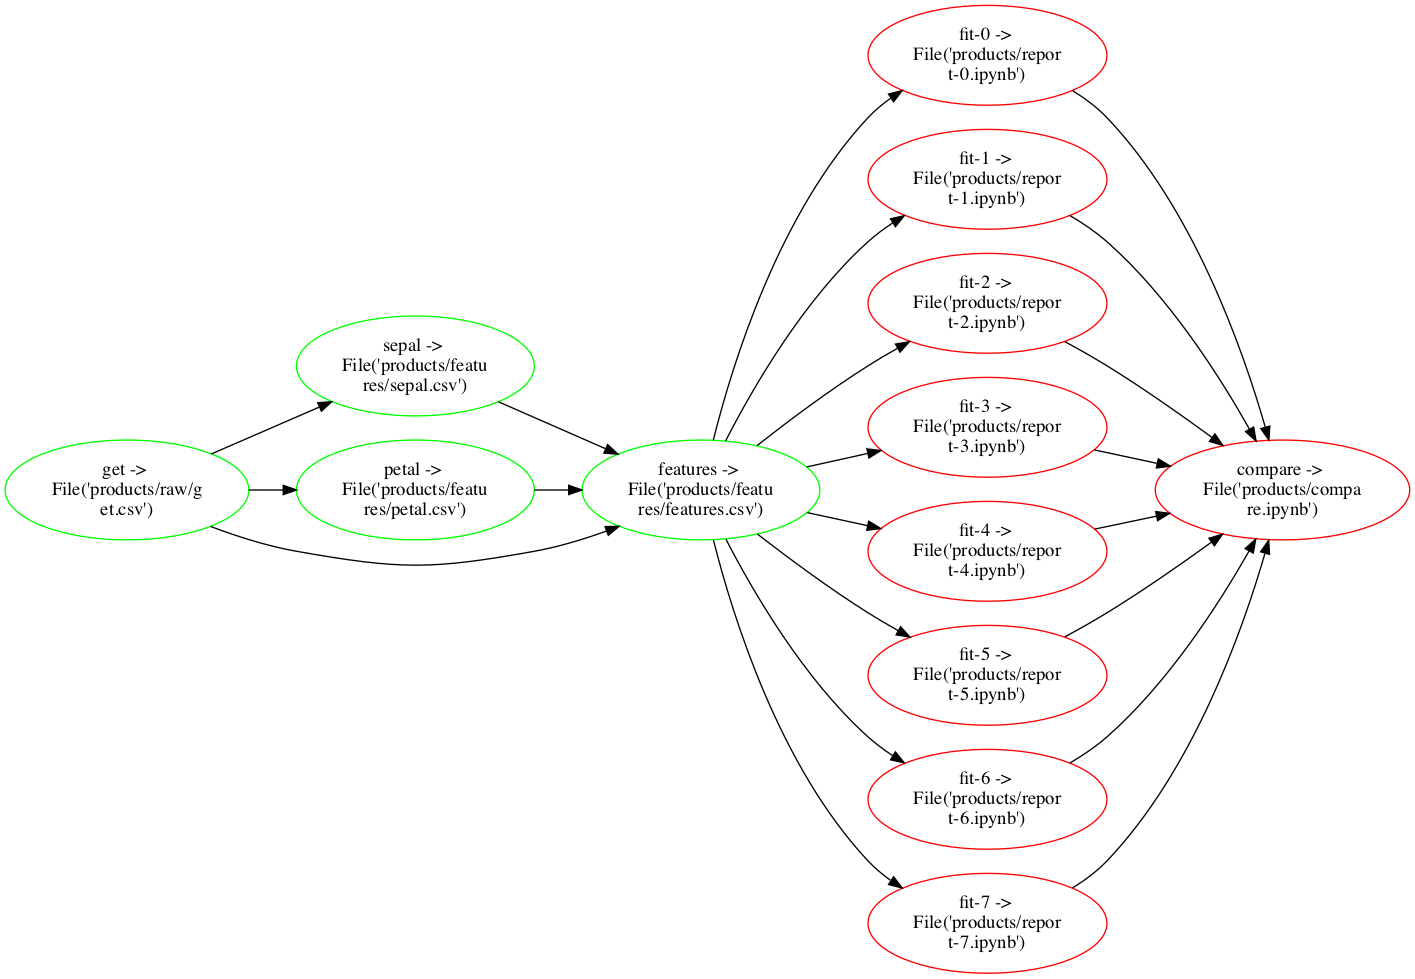

In [3]:
dag = DAGSpec('pipeline.yaml').to_dag()

# this is the same as doing "ploomber plot" from the command line
dag.plot()

The pipeline gets the iris dataset (`get` task), creates a few features (`sepal`, and `petal` tasks), and joins everything into a single file (`features` task). Then we see 8 in parallel (`fit-0` to `fit-7` tasks), they all use the same script as source but train different models, we log the models to MLflow here. Finally, we have a task (`compare`) that uses MLflow's API to query the runs and prints the best overall experiment.

Now that we have a high-level idea of what the pipeline is doing, let's look at the `pipeline.yaml`:

In [4]:
display_file('pipeline.yaml')


```yaml
executor: parallel

tasks:
  - source: tasks.raw.get
    product: products/raw/get.csv

  - source: tasks.features.sepal
    product: products/features/sepal.csv

  - source: tasks.features.petal
    product: products/features/petal.csv

  - source: tasks.features.features
    product: products/features/features.csv

  - source: scripts/fit.py
    name: fit-
    # we need to turn this off because parameters depend on the type of model
    static_analysis: false
    product: products/report.ipynb
    grid:
      - model: sklearn.ensemble.RandomForestClassifier
        n_estimators: [10, 20]
        criterion: [gini, entropy]
        params_names: [[n_estimators, criterion]]
        track: '{{track}}'
        mlflow_tracking_uri: '{{mlflow_tracking_uri}}'
      - model: sklearn.ensemble.AdaBoostClassifier
        n_estimators: [10, 20]
        learning_rate: [0.5, 1.0]
        params_names: [[n_estimators, learning_rate]]
        track: '{{track}}'
        mlflow_tracking_uri: '{{mlflow_tracking_uri}}'
    on_finish: hooks.store_report


  - source: scripts/compare.py
    product: products/compare.ipynb
    params:
      mlflow_tracking_uri: '{{mlflow_tracking_uri}}'
```


The first four tasks are simple, they execute Python functions to prepare the data. The 5th and 6th entries are the interesting ones. Let's analyze the 5th entry first:

In [5]:
display_file('pipeline.yaml', lines=(15, 35))


```yaml

  - source: scripts/fit.py
    name: fit-
    # we need to turn this off because parameters depend on the type of model
    static_analysis: false
    product: products/report.ipynb
    grid:
      - model: sklearn.ensemble.RandomForestClassifier
        n_estimators: [10, 20]
        criterion: [gini, entropy]
        params_names: [[n_estimators, criterion]]
        track: '{{track}}'
        mlflow_tracking_uri: '{{mlflow_tracking_uri}}'
      - model: sklearn.ensemble.AdaBoostClassifier
        n_estimators: [10, 20]
        learning_rate: [0.5, 1.0]
        params_names: [[n_estimators, learning_rate]]
        track: '{{track}}'
        mlflow_tracking_uri: '{{mlflow_tracking_uri}}'
    on_finish: hooks.store_report
```


The task uses `scripts/fit.py` as its source and sets the name to `fit-` so that generated tasks have the same prefix. Then we set `static_analysis` to `false`, the static analysis feature checks that the parameters passed to the task match the ones declared by the script (in the `parameters` cell) but since we'll be passing different parameters depending on the type of model, we have to turn off this feature. We can see that we'll store the output in `products/report.ipynb`.

`grid` is where the magic happens. This feature allows us to pass a grid of parameters and generate many tasks from a single declaration. For example, the first element is stating that we want to train a random forest and vary some of the hyperparameters (`n_estimator`, and `criterion`).

`params_names` is a list of parameters that we are going to vary across experiments, we need to collect all the appropriate values to pass to the model constructor (which depend on the model type), for example:

```pythonthon
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=10, criterion='gini')
```

`track` is a parameter that controls whether to track experiments with MLflow or not, it's turned off by default because we may want to open `scripts/fit.py` and edit it interactively using Jupyter but do not want this to create new experiments on MLflow while doing this. `mlflow_tracking_uri` is the URI that we'll use for MLflow. Note that `track` and `mlflow_tracking_uri` are placeholders and its values are loaded from an `env.yaml` file, whose contents are shown next:

In [6]:
display_file('env.yaml')


```yaml
track: false
mlflow_tracking_uri: 'file:{{root}}/mlruns'
```


We can see that `track` is set to `false`, and `mlflow_tracking_uri` to `file:{{root}}/mlruns`. Ploomber automatically resolves the `{{root}}` placeholder to the parent directory of our `pipeline.yaml` file, but we could have an explicit value instead (e.g., `file:/path/to/directory`).

Let's take a look at the portion of `scripts/fit.py` that uses `track` and `mlflow_tracking_uri`:

In [7]:
display_file('scripts/fit.py', syntax='python', lines=(28, 38))


```python
if track:
    print('tracking with mlflow...')
    mlflow.set_tracking_uri(mlflow_tracking_uri)

    @atexit.register
    def end_run():
        mlflow.end_run()
else:
    print('tracking skipped...')
    mlflow = Mock()
```


If `track` is `True`, then we set the tracking URI and use the built-in `atexit` module to ensure that we call `mlflow.end_run` when our script finishes execution. If `track` is `False`, we mock `mlflow` (using a built-in module) so all our calls to `mlflow` don't do anything.


Now that we explained what each parameter is doing, let's go back to our task declaration:

In [8]:
display_file('pipeline.yaml', lines=(15, 35))


```yaml

  - source: scripts/fit.py
    name: fit-
    # we need to turn this off because parameters depend on the type of model
    static_analysis: false
    product: products/report.ipynb
    grid:
      - model: sklearn.ensemble.RandomForestClassifier
        n_estimators: [10, 20]
        criterion: [gini, entropy]
        params_names: [[n_estimators, criterion]]
        track: '{{track}}'
        mlflow_tracking_uri: '{{mlflow_tracking_uri}}'
      - model: sklearn.ensemble.AdaBoostClassifier
        n_estimators: [10, 20]
        learning_rate: [0.5, 1.0]
        params_names: [[n_estimators, learning_rate]]
        track: '{{track}}'
        mlflow_tracking_uri: '{{mlflow_tracking_uri}}'
    on_finish: hooks.store_report
```


The total number of tasks generate by grid depends on the number of parameters, for the first entry we have:

1. `model` (1 element)
2. `n_estimators` (2)
3. `criterion` (2)
4. `params_names` (1) - see note below
5. `track` (1)
6. `mlflow_tracking_uri` (1)

This will generate a total of `1 * 2 * 2 * 1 * 1 * 1 = 4` tasks.

Note that `params_names` is a list with 1 element. By default, `grid` interprests lists as `"create one task per element on the list"`, but we don't want that, on this case, we want all tasks to receive the complete list and we ensure this by passing a list with a single element.

The next entry on grid is similar and generates another 4 taks.

To see more clearly what paramers each task receives, let's use the `dag` object to print the parameters of the first two `fit-` tasks:

In [9]:
fm = black.FileMode()

tasks_fit = [t for t in dag.values() if 'fit' in t.name]

for task in tasks_fit[:2]:
    if 'fit' in task.name:
        params = black.format_str(str(task.params), mode=fm)
        print(f'{task.name} params:\n{params}')

fit-0 params:
{
    "model": "sklearn.ensemble.RandomForestClassifier",
    "n_estimators": 10,
    "criterion": "gini",
    "params_names": ["n_estimators", "criterion"],
    "track": False,
    "mlflow_tracking_uri": "file:/Users/Edu/dev/projects-ploomber/mlflow/mlruns",
    "upstream": Upstream({"features": File("products/features/features.csv")}),
    "product": File("products/report-0.ipynb"),
}

fit-1 params:
{
    "model": "sklearn.ensemble.RandomForestClassifier",
    "n_estimators": 10,
    "criterion": "entropy",
    "params_names": ["n_estimators", "criterion"],
    "track": False,
    "mlflow_tracking_uri": "file:/Users/Edu/dev/projects-ploomber/mlflow/mlruns",
    "upstream": Upstream({"features": File("products/features/features.csv")}),
    "product": File("products/report-1.ipynb"),
}



You can see that most parameters are the same, except for `criterion` (the first one has `gini`, and the second one `entropy`).

## Running the pipeline

Every parameter declared in `env.yaml` can be switched from the command line, let's get the `--help` information to see hwo to do it:

In [10]:
%%sh
%%bash
ploomber build --help

usage: ploomber [-h] [--log LOG] [--entry-point ENTRY_POINT] [--force]
                [--skip-upstream] [--partially PARTIALLY] [--debug]
                [--env--track ENV__TRACK]
                [--env--mlflow_tracking_uri ENV__MLFLOW_TRACKING_URI]

Build pipeline

optional arguments:
  -h, --help            show this help message and exit
  --log LOG, -l LOG     Enables logging to stdout at the specified level
  --entry-point ENTRY_POINT, -e ENTRY_POINT
                        Entry point, defaults to pipeline.yaml
  --force, -f           Force execution by ignoring status
  --skip-upstream, -su  Skip building upstream dependencies. Only applicable
                        when using --partially
  --partially PARTIALLY, -p PARTIALLY
                        Build a pipeline partially until certain task
  --debug, -d           Drop a debugger session if an exception happens
  --env--track ENV__TRACK
                        Default: False
  --env--mlflow_tracking_uri ENV__MLFLOW_TRACKIN

sh: line 1: fg: no job control


As you can see, we can use `--env--track` to switch the track flag. So let's run the pipeline and switch this value to ensure our experiments are tracked by MLflow:

In [11]:
%%sh
%%bash
ploomber build --env--track true

Finished tasks so far: {'fit-1', 'features', 'fit-5', 'fit-0', 'fit-3', 'sepal', 'fit-6', 'get', 'fit-2', 'fit-7', 'petal', 'compare', 'fit-4'}
Remaining tasks: set()
Finished 13 out of 13 tasks
name      Ran?      Elapsed (s)    Percentage
--------  ------  -------------  ------------
get       False               0             0
sepal     False               0             0
petal     False               0             0
features  False               0             0
fit-0     False               0             0
fit-1     False               0             0
fit-2     False               0             0
fit-3     False               0             0
fit-4     False               0             0
fit-5     False               0             0
fit-6     False               0             0
fit-7     False               0             0
compare   False               0             0


sh: line 1: fg: no job control


That's it! We just trained 8 models in parallel and log them to MLflow! Here's how my MLflow looks like:

![list](images/list.png)

Note that `script/fit.py` organizes each model in a different MLflow experiment:

![experiments](images/experiments.png)

And logs all model parameters and metrics, but it also stores a confusion matrix and the model file:

![artifacts](images/artifacts.png)

But more importantly, it stores the executed notebook as an HTML file!

![report](images/report.png)

This is extremely useful for debugging purposes, and we can use `print` statements in our script to log information that we can use for debugging, in case any of our experiments goes wrong, furthermore, since this is an HTML file, it can contain other information such as printed data frames or charts, everything is logged. I'll explain how we achieve this in the next section.

## Storing executed notebooks in MLflow

Ploomber has a feature called "hooks" which allows to run code when a task finishes execution. In our case, we're using it for converting the generated notebook to HTML and log it to MLflow:

In [12]:
display_file('hooks.py', syntax='python')


```python
import mlflow
from nbconvert import HTMLExporter
from sklearn_evaluation import NotebookIntrospector


def store_report(product, params):
    if params['track']:
        nb = NotebookIntrospector(product)
        run_id = nb['mlflow-run-id'].strip()

        # https://nbconvert.readthedocs.io/en/latest/config_options.html#preprocessor-options
        exporter = HTMLExporter()
        # hide code cells
        exporter.exclude_input = True
        body, _ = exporter.from_filename(product)

        with mlflow.start_run(run_id):
            mlflow.log_text(body, 'nb.html')
```


Note that we add `product` and `params` to the function signature to tell Ploomber that we want the `product` that the task generates and the task params. We use this to load the generated notebook and convert it to HTML. Then we retrieve the run id and log it to MLflow.

*Note: we're using sklearn_evaluation.NotebookIntrospector to retrieve mlflow's run id from the executed notebook, [click here](https://sklearn-evaluation.readthedocs.io/en/stable/user_guide/NotebookCollection.html) to learn more about how this works*

To register the hook, we add the `on_finish` entry to the task declaration:

In [13]:
display_file('pipeline.yaml', lines=(30, 35))


```yaml
        learning_rate: [0.5, 1.0]
        params_names: [[n_estimators, learning_rate]]
        track: '{{track}}'
        mlflow_tracking_uri: '{{mlflow_tracking_uri}}'
    on_finish: hooks.store_report
```


## Running experiments in parallel

To run tasks in parallel, we must include the following in our `pipeline.yaml` file:

```yaml
executor: parallel

# pipeline.yaml continues...
```

But if we want to run tasks serially, we can remove it. We may want to do this if each experiment needs too much memory and it's not possible to run them all at once.

## Selecting the best experiment

The final task in our pipeline generates a notebook that prints the best experiment overall. We want this task to execute after all our experiments are done, but we cannot list all of them because the exact number may change (e.g., suppose you add more parameters to the random forest grid). Ploomber allows us wildcards to solve this:

In [14]:
display_file('scripts/compare.py', syntax='python', lines=(17, 19))


```python
# + tags=["parameters"]
upstream = ['fit-*']
```


Our `scripts/compare.py` declares upstream dependencies with the wildcard `fit-*`, which translates to "execute all tasks that match the `fit-*` pattern before `scripts/compare.py`".

## Using functions instead of scripts/notebooks

Ploomber gives users the flexibility to use functions, scripts or notebooks as tasks. If you prefer to use functions, you can use the same code and put it in a function. The advantage of using a script or notebook is that you can log all the output, just like we showed earlier.